## Chapter 9. Dynamic macro I: Infinite horizon models
Reference: Fehr, H. and Kindermann, F. 2018. <i>Introduction to Computational Economics Using Fortran.<i/> Oxford University Press. pp. 323-405.

In [2]:
# Import sources for all programs in this notenbook

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import root, minimize
import math as ma
plt.rcParams["figure.figsize"] = (11, 5)
## sourse: https://programtalk.com/vs2/python/3701/dolo/dolo/numeric/discretization/discretization.py/
from discretize_tools import rouwenhorst ## import 'rouwenhorst' discretize method from the file 'discretize_tools'

Note: the LHS of the figure is not consistent with in text.
$\delta k_t$ or $\delta k_t + c_t$???

Euler equation error = 2.28764e-05


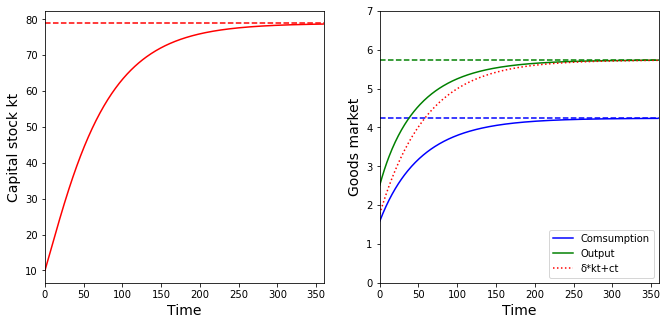

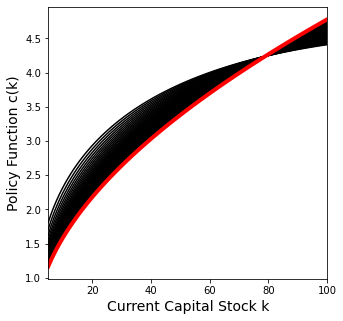

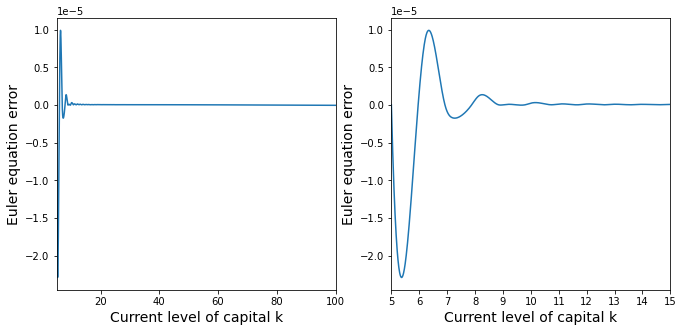

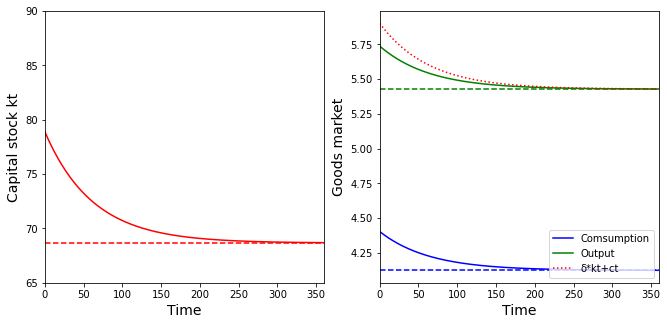

In [8]:
# Program 9.1 The Ramsey economy with root-finding and interpolation
# & Program 9.2 Simulating a time path of the economy
# Define Ramsey model using 'class' settings

class Ramsey:
    def __init__(self,          #defining parameters, use self.'' to call for each parameter in the model
                 γ=.5,          #intertemporal elasticity of substitution
                 α= .4,         #capital share
                 β = .99,       #discount factor
                 δ = .019,      #depreciation
                 k0 = 10,       #initial capital stock
                 n = 100,       #number of grid points
                 T = 360,       #number of periods
                 lower = 5,     #per capita capital level lower bound
                 upper = 100,   #per capita capital level upper bound
                 gy = .0,       #government expenditure fraction
                 by = .0,       #debt fraction
                 τr = .0,       #capital income tax rate
                 gov = False):  #False if do not include government expenditure, True if otherwise
        self.gov = gov ## this variable controls whether or not the government expenditure exists in this RBC model
        self.γ,self.α,self.β,self.δ = γ, α, β, δ  #setting each parameter to its corresponding value defined in 'self'
        self.θ,self.k0,self.kl,self.ku = 1/self.β - 1,k0, lower, upper
        self.τr,self.by,self.gy = τr, by, gy
        self.g_bar = gy * (self.α/(self.θ+self.δ))**(self.α/(1-self.α)) #calculate government expenditure
        self.k_steady, self.c_steady = self.steady_state() ## calculate the steady state capital stock and consumption
        self.k_grid = np.linspace(lower,upper,n) # discretize k into n nodes
        self.c = self.policy(show = True) #calculate foc consumption level
        self.T = T
        self.kt, self.ct, self.τw, self.yt, self.ct = self.dynamics_plot(show = True) ##calculate transition path
        self.U = self.Utility_Steady() ## calculate the steady state utility using the function/property Utility_Steady()
        self.U0 = self.Utility_Transition() ## calculate the transition path utility using the function/property Utility_Steady()
        
        
    def steady_state(self):
        """Calculating steady state capital level and consumption level"""
        k = (self.α/((self.θ/(1-self.τr))+self.δ))**(1/(1-self.α))
        c = k**self.α-self.δ*k - self.g_bar
        return k,c
    
    def policy(self, maxiter = 1000,tol = 1e-6,verbose = False, plot=False,show = False):
        """This property calculates consumption level for each k gridpoints in steady state"""
        k = self.k_grid
        c_old = k**self.α - self.δ*k ## initialize the consumption, c_old is 1-dimensional vector
        if plot: ## we can plot the convergence path if we want
            fig, ax = plt.subplots(1,figsize=(5,5))
            ax.set_xlim(self.kl,self.ku)
        for i in range(maxiter):
            S = interp1d(k,c_old,kind = 'cubic',fill_value="extrapolate") ## interpolate the old policy function
            kplus = (1-self.δ)*k + k**self.α - c_old - self.g_bar ## calculate the future capital stock
            c_new = (self.β*(1+(1-self.τr)*(self.α*kplus**(self.α-1)-self.δ)))**(-self.γ)*S(kplus) ## the new policy function
            if plot:
                ax.set_xlabel('Current Capital Stock k', fontsize = 14) 
                ax.set_ylabel('Policy Function c(k)', fontsize = 14)
                ax.plot(k,c_old,color = 'k') # for each iteration, we plot the policy functions (old will be replaced anyway)
            if verbose: ## if 'verbose = True', we can easily see the detail of the convergence, this is
                # quite essential when we coding/debugging. However, we can turn if off by setting 'verbose = False'
                # after the code is perfect.
                print('Iteration = {}, error = {}'.format(i,np.linalg.norm(c_new-c_old)))
            if np.linalg.norm(c_new-c_old) < tol: ## here we use the norm of the difference of the c_old and c_new to be the error
                if plot:
                    ax.plot(k,c_old,color = 'r',linewidth = 4)
                break
            else:
                c_old = c_new
        if i >=maxiter:
            raise RuntimeError("Maximum iteration reached")
        if show:
            return c_new
        
    
    def dynamics_plot(self, show = False):
        '''
        This property/function calculate the transition path of the main variables of the RBC model.
        Return: return kt,ct,τw,yt,ct
        '''
        kt = np.zeros(self.T)  #capital time trend
        ct = np.zeros(self.T)  #consumption time trend
        τw = np.zeros(self.T)  #labour income tax rate that balance the budget
        S = interp1d(self.k_grid,self.c,kind = 'cubic',fill_value="extrapolate")
        # First of all, we need to interpolate the policy function, so that we can calculate the transition path based on
        # the policy function we have calculated
        gov = self.gov ## if gov = True, then we need to involve the government expenditure
        if gov:
            kt[0] = (self.α/(self.θ+self.δ))**(1/(1-self.α))
        else:
            kt[0] = self.k0
        for t in range(self.T):
            ct[t] = S(kt[t]) ## the current consumption is calculated from the interpolation of the policy function
            if t < self.T-1:
                kt[t+1] = kt[t]**self.α +(1-self.δ)*kt[t] -ct[t] - self.g_bar  ## law of motion for capital
        yt = kt**self.α   ## calculate the output
        bt = self.by * yt ## calculate the debt
        bt[0] = .0        ## debt in the initial period is 0
        rt = kt**(self.α-1) - self.δ ## calculate the interest rate
        wt = (1-self.α)*kt**self.α   ## calculate the wage rate
        for t in range(self.T-1):    ## for each period, income tax rate is calculated to balance the budget
            τw[t] = (self.g_bar + (1 + rt[t])*bt[t] - bt[t+1] -self.τr*rt[t]*(kt[t]+bt[t]))/wt[t]
            
        τw[-1]=(self.g_bar + rt[-1]*bt[-1] -self.τr*rt[-1]*(kt[-1]+bt[-1]))/wt[-1] #last period income tax rate
        ## for the last period, we assume that all the variable are in their steady state
        if not show:
            fig1, (ax1,ax2) = plt.subplots(1,2)
            ax1.set_xlim(0,self.T)
            ax1.plot(np.arange(self.T),kt,color = 'r')
            ax1.set_xlabel('Time', fontsize = 14)
            ax1.set_ylabel('Capital stock kt', fontsize = 14)
            if gov:
                ax1.set_ylim(65,90) 
            ax1.hlines(self.k_steady,0,self.T,color = 'r',linestyle = 'dashed')
            ax2.set_ylabel('Comsumption', fontsize = 14)
            ax2.set_xlim(0,self.T)
            ax2.set_xlabel('Time', fontsize = 14)
            ax2.plot(np.arange(self.T),ct,color = 'b',label='Comsumption')
            ax2.plot(np.arange(self.T),kt**self.α, color = 'g',label = 'Output')
            ax2.plot(np.arange(self.T),kt*self.δ+ct,'r',linestyle ='dotted',label = 'δ*kt+ct')
            ax2.hlines(self.c_steady,0,self.T,color = 'b',linestyle = 'dashed')
            ax2.hlines(self.k_steady**self.α,0,self.T,color = 'g',linestyle = 'dashed')
            if not gov:
                ax2.set_ylim(0,7)
            ax2.set_ylabel('Goods market', fontsize = 14)
            ax2.legend(loc = 'lower right')
        if show: ## show: we can depress the plot of transition path if we want (set show = True)
            return kt,ct,τw,yt,ct
        
    def Utility_Steady(self):
        """This function calculates the steady state utility according to the utility function"""
        return 1/(1-self.β)*(self.ct[-1]**(1-1/self.γ)/(1-1/self.γ))
    
    def Utility_Transition(self):
        """This function calculates the utilities in each transition period"""
        U = .0
        for t in range(self.T):
            U += self.β**t * (self.ct[t]**(1-1/self.γ)/(1-1/self.γ))  #'+=' stands for U = U + ...
        U += self.β**self.T*self.U
        return U
        
        
    def Euler_equation_error(self,plot=False):
        '''
        This property calculates and plots the Euler equation error 
        '''
        k = np.linspace(self.kl,self.ku,10000)
        S = interp1d(self.k_grid,self.c,kind = 'cubic',fill_value="extrapolate")
        kplus = (1-self.δ)*k +k**self.α - S(k) # vector k+ on p.333

        EER = S(k) -(self.β*(1+self.α*kplus**(self.α-1)-self.δ))**(-self.γ)*S(kplus) ## Euler equation residual on p.333
        
        error = EER/S(k)  ## Euler equation error
        print('Euler equation error = {:1.5e}'.format(np.amax(np.abs(error))))
        if plot:
            fig2, (ax1,ax2) = plt.subplots(1,2)
            ax1.plot(k,error)
            ax1.set_xlim(self.kl,self.ku)
            ax1.set_xlabel('Current level of capital k', fontsize = 14)
            ax1.set_ylabel('Euler equation error', fontsize = 14)
            ax2.plot(k,error)
            ax2.set_xlim(5,15)
            ax2.set_xticks(np.arange(5,16))
            ax2.set_xlabel('Current level of capital k', fontsize = 14)
            ax2.set_ylabel('Euler equation error', fontsize = 14)

model1 = Ramsey()  ## model1 is a Ramsey model with default setting           
model1.dynamics_plot() ## plot the trasition path 
model1.policy(plot = True) ## we can plot convergence pated
# Figure 9.2 Euler equation residual of the Ramsey economy
model1.Euler_equation_error(plot=True)  ## plot the euler equation error


model2 = Ramsey(τr = 0.2,gov = True) ## model2 is a Ramsey model with government expenditure
model2.dynamics_plot()  ## plot the trasition path
# model2.Euler_equation_error(plot=True)


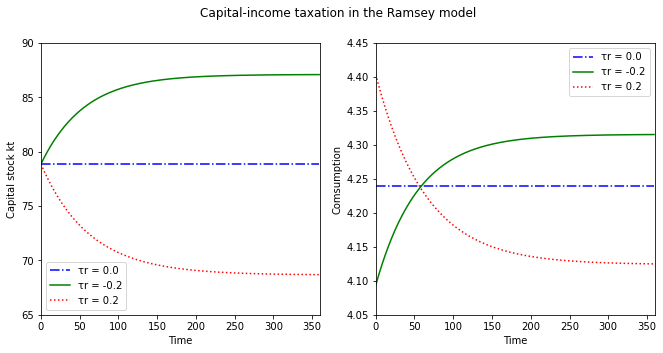

In [3]:
# Figure 9.3 Capital income taxation in the Ramsey economy
col = ['b','g','r']
lin = ['dashdot','-','dotted']
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Capital-income taxation in the Ramsey model')
ax1.set_ylabel('Capital stock kt')
ax1.set_xlabel('Time')
ax1.set_ylim(65,90)
ax2.set_ylabel('Consumption ct')
ax2.set_ylim(4.05,4.45)
for j,i in enumerate([0.0,-.2,.2]):
    model = Ramsey(gov=True,τr = i)
    ax1.plot(np.arange(model.T),model.kt,color = col[j],linestyle = lin[j],label='τr = {}'.format(i))
    ax1.set_xlim(0,model.T)
    ax1.legend(loc = 'best')
    ax2.plot(np.arange(model.T),model.ct,color = col[j],linestyle = lin[j],label='τr = {}'.format(i))
    ax2.set_ylabel('Comsumption')
    ax2.set_xlim(0,model.T)
    ax2.set_xlabel('Time')   
    ax2.legend(loc = 'upper right')

Note: the table below is different with in text in the $\tau_w$

In [4]:
# Table 9.1 Steady-state analysis of tax structure
print('='*79)
print('{:>4s},{:>7s}, {:>6s}, {:>6s}, {:>6s}, {:>6s}, {:>6s}, {:>6s}, {:>7s}, {:>7s}'\
      .format('gy', 'τr', 'by', 'τw',  'k/y',  'c/y', 'g/y', 'c',  'U',    'U0'))
print('='*79)
for j,i in enumerate([0.0,-.2,.2]):
    model = Ramsey(gov=True, τr = i)
    print('\n{:>4.1f},{:>7.1f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.3f}, {:>6.3f}'\
          .format(model.gy*100,model.τr*100,model.by,model.τw[-1]*100,model.kt[-1]*100/(4*model.yt[-1]),\
                  model.ct[-1]*100/model.yt[-1],model.g_bar/model.yt[-1],model.ct[-1],model.U,model.U0))
for j,i in enumerate([0.0,.2,.4]):
    model = Ramsey(gov=True, gy=0.15, τr = i)
    print('\n{:>4.1f},{:>7.1f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.3f}, {:>6.3f}'\
          .format(model.gy*100,model.τr*100,model.by,model.τw[-1]*100,model.kt[-1]*100/(4*model.yt[-1]),\
                  model.ct[-1]*100/model.yt[-1],model.g_bar*100/model.yt[-1],model.ct[-1],model.U,model.U0))
model = Ramsey(gov=True, gy=0.15,by = .5,τr=0.4)
print('\n{:>4.1f},{:>7.1f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.2f}, {:>6.3f}, {:>6.3f}'\
      .format(model.gy*100,model.τr*100,model.by,model.τw[-1]*100,model.kt[-1]*100/(4*model.yt[-1]),\
              model.ct[-1]*100/model.yt[-1],model.g_bar*100/model.yt[-1],model.ct[-1],model.U,model.U0))

  gy,     τr,     by,     τw,    k/y,    c/y,    g/y,      c,       U,      U0

 0.0,    0.0,   0.00,   0.00, 343.63,  73.88,   0.00,   4.24, -23.587, -23.587

 0.0,  -20.0,   0.00,  24.09, 364.70,  72.28,   0.00,   4.32, -23.173, -23.613

 0.0,   20.0,   0.00, -25.32, 316.29,  75.97,   0.00,   4.12, -24.243, -23.629

15.0,    0.0,   0.00,  25.00, 343.63,  58.88,  15.00,   3.38, -29.596, -29.596

15.0,   20.0,   0.00,   1.10, 316.40,  60.12,  15.85,   3.27, -30.626, -29.657

15.0,   40.0,   0.00, -23.82, 279.87,  61.60,  17.20,   3.08, -32.442, -29.921

15.0,   40.0,   0.50, -20.30, 279.87,  61.60,  17.20,   3.08, -32.442, -29.921


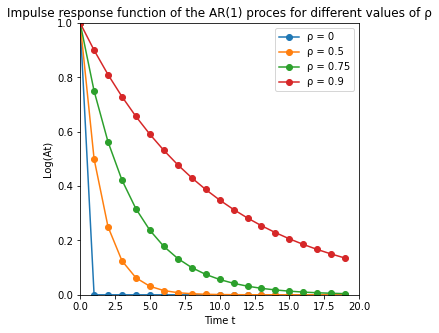

In [5]:
# Figure 9.4 Impulse response function of the AR(1) process for different values of ρ

T = 20
η = np.zeros(T)
η[0] = 1
fig, ax = plt.subplots(1,figsize= (5,5))
ax.set_xlim(0,20)
ax.set_ylim(0,1)
ax.set_ylabel('Log(At)')
ax.set_xlabel('Time t')
ax.set_title('Impulse response function of the AR(1) proces for different values of ρ')
for ρ in [0,0.5,0.75,0.9]:
    for t in range(1,T):
        η[t] = η[t-1]*ρ
    ax.plot(np.arange(T),η,marker ='o',label = 'ρ = {}'.format(ρ))
    ax.legend()

Text(0, 0.5, 'Probability density function')

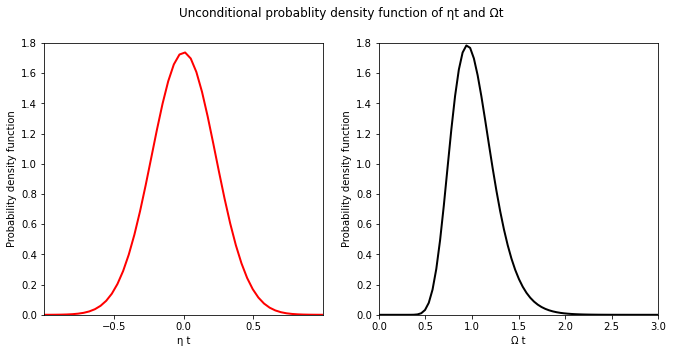

In [6]:
# Figure 9.5 Unconditional probability density function of ηt (technology shock) and Ωt (conditional distribution)

from scipy.stats import norm, lognorm

x = np.linspace(-1,3,100)

ρ = 0.9   #persistence
σe = 0.1  #st.d. of noise e (standard deviation)
σu = (σe**2/(1-ρ**2))**0.5  #st.d. of η
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Unconditional probablity density function of ηt and Ωt')

eta = norm(scale = σu)
ax1.set_xlim(-1,1)
ax1.set_ylim(0,1.8)
ax1.set_xticks([-0.5,0,0.5])
ax1.plot(x, eta.pdf(x), 'r-', lw=2, label='frozen pdf')
ax1.set_xlabel('η t')
ax1.set_ylabel('Probability density function')

σo = (np.exp(σu**2)*np.exp(σu**2-1))**0.5  #st.d. of Ω
omega = lognorm(s=σu,scale = np.exp(0.0))  #Ω
ax2.set_xlim(0,3)
ax2.set_ylim(0,1.8)
ax2.set_xticks([0,0.5,1,1.5,2,2.5,3])
ax2.plot(x, omega.pdf(x), 'k-', lw=2, label='frozen pdf')
ax2.set_xlabel('Ω t')
ax2.set_ylabel('Probability density function')

In [7]:
# Program 9.3 The stochastic growth model: policy function iteration
# & Program 9.4 Speeding up the stochastic growth model

class StochasticGrowth:
    def __init__(self,        #defining parameters, use self.'' to call for each parameter in the model
                 γ=.5,        #intertemporal elasticity of substitution
                 α= .4,       #capital share
                 β = .99,     #discount factor
                 δ = .019,    #depreciation rate
                 n = 100,     #number of grid points of k
                 m = 21,      #number of shocks
                 lower = 50,  #per capita capital level lower bound
                 upper = 110, #per capita capital level upper bound
                 ρ = 0.95,    #persistence in AR(1) process used in rouwenhorst method
                 σe = 0.007): #st.d. of noise e
        self.γ, self.α, self.β, self.δ = γ, α, β, δ
        self.m, self.n = m,n
        self.kl,self.ku = lower,upper
        self.k_grid = np.linspace(lower,upper,n) #set up gridpoints for k
        self.η, self.π = rouwenhorst(ρ,σe,m) ## we need to discretize the shock state space using rouwenhorst method
        self.c = self.policy(speed = True) # if speed = True, then we use the faster iteration process to calculate the policy function
        # now, c is a 2-dimensional matrix
        self.Ω, self.kt, self.ct = self.dynamic(show = True) #calculate transition path for technology shocks, per capita capital, and consumption 
        
    def policy(self,tol = 1e-6, maxiter = 10000, verbose=False, speed = False):
        """
        This property calculates the consumption level for each gridpoint in steady state
        """
        k = self.k_grid
        π = np.asarray(self.π) #transition matrix
        η = np.asarray(self.η) #states of shocks
        c_old = (k[:,np.newaxis]**self.α)@np.exp(η)[np.newaxis,:] ## n*m matrix
        c_new = np.zeros((self.n,self.m))
        
        if speed: ## A faster method calculates the RHS of foc first and then interpolate 
            #This is for Program 9.4
            RHS = np.zeros((self.n,self.m))
            for ite in range(maxiter): #law of motion for capital
                kplus = (1-self.δ)*np.repeat(k[:,np.newaxis],self.m,axis=1)+(k[:,np.newaxis]**self.α)@np.exp(η)[np.newaxis,:] - c_old
                for i in range(self.n):
                    for j in range(self.m): #according to foc
                        aux = π[j,:]@((1+np.exp(η[:])*self.α*k[i]**(self.α-1)-self.δ)*c_old[i,:]**(-1/self.γ))
                        RHS[i,j] = (self.β*aux)**(-self.γ)

                S = interp2d(η,k,RHS,kind = 'cubic') ## we interpolate the whole RHS of the equation

                for j in range(self.m):
                    c_new[:,j] = np.reshape(S(η[j],kplus[:,j]),self.n) ## calculate the new policy function
                if verbose:
                    print('Iteration = {}, error = {:.2e}'.format(ite,np.linalg.norm(c_new-c_old)))
                if np.linalg.norm(c_new-c_old)<tol:
                    break
                else:
                    c_old = c_new.copy() # when we use element-wise assignment, must use .copy()!!!!
        
        else:  ## A normal method interpolates first and then calculate for matrix transitions
            for ite in range(maxiter):
                S = interp2d(η,k,c_old,kind = 'cubic')
                kplus = (1-self.δ)*np.repeat(k[:,np.newaxis],self.m,axis=1)+(k[:,np.newaxis]**self.α)@np.exp(η)[np.newaxis,:] - c_old
                for i in range(self.n):
                    for j in range(self.m): #according to foc results
                        cplus = S(η[:],kplus[i,j])
                        aux = π[j,:]@((1+np.exp(η[:])*self.α*kplus[i,j]**(self.α-1)-self.δ)*cplus**(-1/self.γ))
                        c_new[i,j] = (self.β*aux)**(-self.γ)
                if verbose:
                    print('Iteration = {}, error = {:.2e}'.format(ite,np.linalg.norm(c_new-c_old)))
                if np.linalg.norm(c_new-c_old)<tol:
                    break
                else:
                    c_old = c_new.copy() # when we use element-wise assignment, must use .copy()!!!!

        if ite >=maxiter:
            raise RuntimeError("Maximum iteration reached")
        else:
            return c_new
        
    def plot_policy(self):
        """This property polts the policy function c with respect to k"""
        from matplotlib.collections import LineCollection

        n = len(range(0,model.m,int(model.m/4))) # the numbers of lines

        x = model.k_grid
        col = [(0.7,i,0.6,1) for i in np.linspace(0,1,n)] # a sequence of (0.7,0,0.6,1) to (0.7,1,0.6,1)
        fig, ax =plt.subplots(1,figsize=(5,5))

        ax.set_xlim(model.kl,model.ku)
        ax.set_ylim(3,5.5)
        ax.set_title('Policy functions of the stochastic growth model')
        ax.set_xlabel('Current level of k')
        ax.set_ylabel('Policy function c(k)')

        leg = ['']*n
        for j,i in enumerate(range(0,model.m,int(model.m/4))):
            y = model.c[:,i] # y is assigned with model consumption
            seg = [np.column_stack([x,y])] # assign all (x,y) points
            lineseg = LineCollection(seg,linewidth=7, colors=col[j]) 
            ax.add_collection(lineseg)
            leg[j] = 'η = {:.2f}'.format(model.η[i])

        ax.legend(leg,loc = 'upper left')   
            
    
    def dynamic(self, T = 5000, plot = False, show = False, k0 = 79):
        """This function calculates the transition path for shocks, the policy function and capital level"""
        from simulate import simulate_AR #call simulate_AR function from outside file 'simulate'

        ηt = simulate_AR(self.π, self.η, T = T) #simulate for AR(1) process
        Ω = np.exp(ηt) # take exponential of η to get Ω
        
        if plot:
            # plot Ω
            fig1, ax = plt.subplots(1,figsize = (5,5))
            ax.plot(np.arange(T),Ω)
            ax.set_xlim(0,T)
            ax.set_ylim(np.amin(Ω),np.amax(Ω))
            ax.set_xlabel('Time t')
            ax.set_ylabel('Technology level Ωt')
            ax.set_title('Simulate technology path')
        
        S = interp2d(self.η,self.k_grid,self.c,kind = 'cubic') #interpolate

        kt = np.zeros(T)
        kt[0] = k0
        ct = np.zeros(T)

        for t in range(T):
            ct[t] = S(ηt[t],kt[t]) #calculate for each new ct
            if t < T - 1:
                kt[t+1] = (1-self.δ)*kt[t] + Ω[t]*kt[t]**self.α - ct[t] #law of motion for k

        if plot:
            fig2, (ax1,ax2) = plt.subplots(1,2)
            fig2.suptitle('Simulated paths for consumption and capital')
            #This plots ct
            ax1.plot(np.arange(T),ct,'g')
            ax1.set_xlim(0,T)
            ax1.set_ylim(np.amin(ct),np.amax(ct))
            ax1.set_xlabel('Time t')
            ax1.set_ylabel('Consumption ct')

            #This plots kt
            ax2.plot(np.arange(T),kt,'r')
            ax2.set_xlim(0,T)
            ax2.set_ylim(np.amin(kt),np.amax(kt))
            ax2.set_xlabel('Time t')
            ax2.set_ylabel('Capital Stock kt')
        if show:
            return Ω, kt, ct
    
            

model = StochasticGrowth() #run for the stochastic growth model




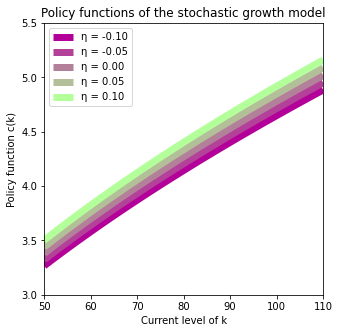

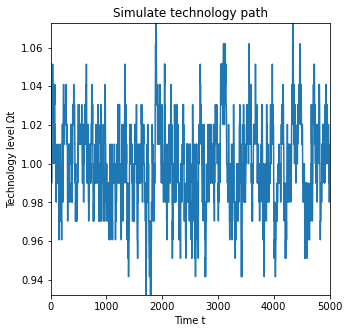

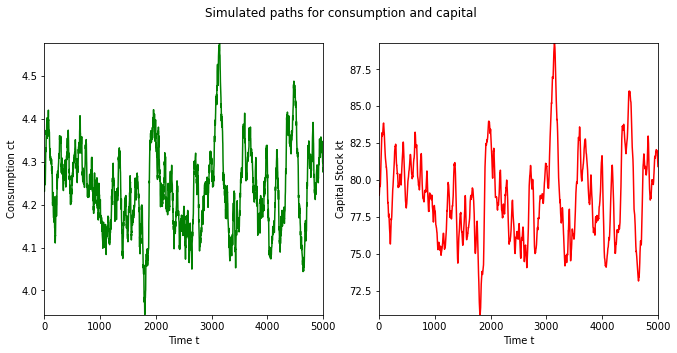

In [8]:
model.plot_policy() ## Figure 9.6 Policy functions of the stochastic growth model
model.dynamic(plot = True) ## Figure 9.8 Simulated technology path and 9.9 Simulated paths for consumption and capital

In [9]:
# Program 9.5 The RBC model: policy function iteration

class RBC:
    
    def __init__(self,
                 γ =.5,      # intertemporal elasticity of substitution
                 α = .4,     # capital share
                 ν = .36,    # taste parameter for consumption
                 β = .99,    # discount factor
                 δ = .019,   # depreciation rate
                 n = 100,    # number of gridpoints
                 m = 21,     # number of shock states
                 lower = 10, # lower bound of k
                 upper = 40, # upper bound of k
                 ρ = .95,    # persistence
                 σe = .007): # variance of noise
        self.γ, self.α, self.ν, self.β, self.δ = γ, α, ν, β, δ
        self.m, self.n = m,n
        self.σe, self.ρ = σe, ρ
        self.kl,self.ku = lower,upper
        self.k = np.linspace(lower,upper,n)
        self.η, self.π = rouwenhorst(ρ,σe,m)
        self.c, self.l, self.S= self.policy()
        self.ηt, self.kt, self.ct, self.lt, self.yt, self.it, self.rt, self.wt = self.dynamic()
        # transition of shocks, capital, consumption, labour, output, investment, interest rate, wage rate


    def policy(self, tol = 1e-6, maxiter = 10000, verbose = False):
        """
        This property calculates the consumption level for each gridpoint in steady state
        """
        #call values from defined in 'self'
        k = self.k
        π, η, α, γ, ν, δ, β= self.π, self.η, self.α, self.γ, self.ν, self.δ, self.β
        egam = 1-1/γ # denominator of utility function
        m, n = self.m, self.n
        
        l = np.ones((n,m))-0.7 #matrix of 0.3, labour supply
        c_old = ((k[:,np.newaxis]**α)@np.exp(η)[np.newaxis,:])*l**(1-α) # get optimal consumption function
        c_new = c_old.copy()
        RHS = np.zeros((n,m))
        

        def foc(l):
            """This property calculates the first-order conditions of the program"""
            # calculate optimal actual consumption level
            c = ν/(1-ν)*(1-l)*np.exp(η[j])*(1-α)*(k[i]/l)**α  # below equation 9.14 on p.358
            # calculate future capital
            kplus = (1-δ)*k[i] + np.exp(η[j])*k[i]**α*l**(1-α)-c # below equation 9.14 on p.358
            # evaluate spline function
            foc = S(η[j],kplus)
            if kplus > self.ku:
                foc += (RHS[-1,j] - RHS[-2, j])/(k[-1]-k[-2])*(kplus-self.ku) 
            # evaluate first-order condition
            foc = ν*(c**ν*(1-l)**(1-ν))**egam/c - foc**(-1/γ)
            return foc
        
        for ite in range(maxiter):
            for i in range(n):
                for j in range(m):
                    marg_util = ν*(c_new[i,:]**ν*(1-l[i,:])**(1-ν))**egam/c_new[i,:] # marginal utility
                    aux = π[j,:]@((1+np.exp(η)*α*(k[i]/l[i,:])**(α-1)-δ)*marg_util) # 
                    RHS[i,j] = (β*aux)**(-γ)
            S = interp2d(η,k,RHS) # interpolate a surface
            
            for i in range(n):
                for j in range(m):
                    l[i,j] = root(foc,x0 = l[i,j]).x  # finds root of foc
                    c_new[i,j] = ν/(1-ν)*(1-l[i,j])*np.exp(η[j])*(1-α)*(k[i]/l[i,j])**α # calculates new consumption

            if verbose:
                print('Iteration = {}, error = {:.2e}'.format(ite,np.linalg.norm(c_new-c_old)))
            if np.linalg.norm(c_new-c_old)<tol:
                break
            else:
                c_old = c_new.copy()
                
        if ite >=maxiter:
            raise RuntimeError("Maximum iteration reached")
        else:
            return c_new, l, S
        
        
    def dynamic(self, T = 10000, k0 = 15):
        '''
        This function returns the dynamic transition of the RBC model.
        Inputs:
        T = 10000: Time periods simulated
        k0 = 15: initial capital stock
        Returns:
        ηt, kt, ct, lt, yt, it, rt, wt
        '''
        
        S1 = interp2d(self.η,self.k,self.c) # interpolate for consumption
        S2 = interp2d(self.η,self.k,self.l) # interpolate for labour supply

        
        kt = np.zeros(T)
        ct = np.zeros(T)
        lt = np.zeros(T)
        yt = np.zeros(T)
        it = np.zeros(T)
        rt = np.zeros(T)
        wt = np.zeros(T)
        ηt = np.zeros(T)
        
        ss = int(self.m/2) + 1  #

        for t in range(T):
            if t == 0:
                kt[t] = k0
            else:
                kt[t] = (1-self.δ)*kt[t-1] + it[t-1]
            ηt[t] = self.η[ss]
            ct[t] = S1(ηt[t], kt[t])
            lt[t] = S2(ηt[t], kt[t])
            yt[t] = np.exp(ηt[t])*kt[t]**self.α*lt[t]**(1-self.α)
            it[t] = yt[t] - ct[t]
            rt[t] = np.exp(ηt[t])*self.α*(lt[t]/kt[t])**(1-self.α)-self.δ
            wt[t] = np.exp(ηt[t])*(1-self.α)*(kt[t]/lt[t])**self.α
        
        from simulate import simulate_AR
        ηt = simulate_AR(self.π, self.η, T = T)

        for t in range(T):
            if t == 0:
                kt[t] = kt[-1]
            else:
                kt[t] = (1-self.δ)*kt[t-1] + it[t-1]
            ct[t] = S1(ηt[t], kt[t])
            lt[t] = S2(ηt[t], kt[t])
            yt[t] = np.exp(ηt[t])*kt[t]**self.α*lt[t]**(1-self.α)
            it[t] = yt[t] - ct[t]
            rt[t] = np.exp(ηt[t])*self.α*(lt[t]/kt[t])**(1-self.α)-self.δ
            wt[t] = np.exp(ηt[t])*(1-self.α)*(kt[t]/lt[t])**self.α
      
    
        return ηt, kt, ct, lt, yt, it, rt, wt
    
    def Euler_equation_error(self, plot = False):
        '''
        This property calculates and plots the Euler equation error 
        '''
        c = self.c #consumption
        l = self.l #labour supply
        k = self.k #capital
        η = self.η #shocks
        S = self.S #interpolation function

        kplus = (1-self.δ)*k[:,np.newaxis] + ((k[:,np.newaxis]**self.α)@np.exp(η)[np.newaxis,:])*l**(1-self.α) - c

        RHS = np.zeros((self.n,self.m))

        for i in range(self.n):
            for j in range(self.m):
                RHS[i,j] = S(η[j],kplus[i,j])**(-1/self.γ)

        Err = c - self.ν*(c**self.ν*(1-l)**(1-self.ν))**(1-1/self.γ)/RHS

        error = Err/S(η,k)

        fig, ax = plt.subplots(1,figsize= (5,5))
        for i in range(0,int(self.m),5):
            ax.plot(self.k, error[:,i] , label = 'η = {:.2f}'.format(η[i]))
        ax.set_title('Eluer equation errors')
        ax.legend()


        return np.amax(error)


Note: The first row below (r = 0.01) is not consistent with the textbook!

In [10]:
# Table 9.2 Stochastic properties of the RBC model
model = RBC() #run for RBC model

# simulate dynamic transitions
model.ηt, model.kt, model.ct, model.lt, model.yt, model.it, model.rt, model.wt = model.dynamic(T=50000)
# mean
Ex = lambda x : np.sum(x)/(len(x)) 
# coefficient of vairiation
CV = lambda x: (np.sum((x - Ex(x))**2)/(len(x)-1))**0.5/Ex(x)
# correlation
Cor = lambda x, y : np.sum((x - Ex(x))*(y - Ex(y)))/(((np.sum((x - Ex(x))**2)/(len(x)-1))**0.5)*((np.sum((y - Ex(y))**2)/(len(y)-1))**0.5))/(len(x) - 1)

print('Table 9.2 Stochastic peroperties of the RBC model')
print('='*70)
print(' {:>23s} {:>6s} {:>6s} {:>6s} {:>6s} {:>6s} {:>6s}'\
      .format('','c', 'i', 'k',  'l',  'r', 'w'))
print('-'*70)
print(' {:>23s} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f}'\
      .format('Average (in %)',Ex(model.ct)/Ex(model.yt)*100, Ex(model.it)/Ex(model.yt)*100, Ex(model.kt)/Ex(model.yt)*100/4, Ex(model.lt)*100, Ex(model.rt), Ex(model.wt)))
print(' {:>23s} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f}'\
      .format('CV (in % of CV of GDP)',CV(model.ct)/CV(model.yt), CV(model.it)/CV(model.yt), CV(model.kt)/CV(model.yt), CV(model.lt)/CV(model.yt), CV(model.rt)/CV(model.yt), CV(model.wt)/CV(model.yt)))
print(' {:>23s} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f} {:>6.2f}'\
      .format('Correlation with GDP',Cor(model.ct,model.yt), Cor(model.it,model.yt), Cor(model.kt,model.yt), Cor(model.lt,model.yt), Cor(model.rt,model.yt), Cor(model.wt,model.yt)))


Table 9.2 Stochastic peroperties of the RBC model
                              c      i      k      l      r      w
----------------------------------------------------------------------
          Average (in %)  73.89  26.11 343.62  31.35   0.01   3.44
  CV (in % of CV of GDP)   0.70   2.17   0.98   0.31   2.07   0.78
    Correlation with GDP   0.91   0.93   0.74   0.78   0.39   0.97


Note: the slots of level and total are different from the textbook!!

In [11]:
# Program 9.6 Calculating the cost of business-cycle fluctuations

# setting parameters (same as Program 9.5)
α, β, γ, δ, ν = model.α, model.β, model.γ, model.δ, model.ν
σe, ρ = model.σe, model.ρ
egam = 1-1/γ

# Get CV(coefficient of variation) and correlation between consunption and leisure
CVc = CV(model.ct) # CV of consumption
CVl = CV(1-model.lt) # CV of labour supply
Corlc = Cor(model.ct,1-model.lt) #correlation between consumption and labour supply

# calculate the capital, consumption, and leisure level in a economy without fluctuations
μΩ = np.exp(0.5*(σe**2/(1-ρ**2))) # mean of shocks
kstar = (μΩ*α/(1/β - 1 +δ))**(1/(1-α))
lstar = (ν * μΩ*(1-α)*kstar**α)/((1-ν*α)*μΩ*kstar**α - (1-ν)*δ*kstar)
cstar = (μΩ*kstar**α - δ*kstar)*lstar

# Define the utility function
Utility = lambda c, l: (c**ν*(1-l)**(1-ν))**egam/egam

# Calculate the û
ustar = Utility(cstar, lstar)
uμ = Utility(Ex(model.ct),Ex(model.lt))
û = uμ / ustar

# Calculate the expectation of the utility level in a economy with productivity fluctuation
Ev = Ex(Utility(model.ct,model.lt))
# Calcullate Δ
ν̄ = (1-ν)*ν*γ
bc_lev = (û -1)/(ν*egam)
aux = -û/(2*ν*γ)
bc_c = aux * (ν**2 + ν̄ )*CVc**2
bc_l = aux*((1-ν)**2 + ν̄)*CVl**2
bc_cor = aux *2 *(ν*(1-ν) - ν̄) * Corlc*CVc*CVl
bc_tot = bc_lev + bc_c + bc_l + bc_cor

#Calculate the model simulated data
Δ = ((Ev/ustar)**(1/(ν*egam)) - 1) * 100

# Table 9.3 The welfare costs of business-cycle fluctuations
print('Table 9.3 The welfare costs of business-cycle fluctuations')
print('='*68)
print(' {:>23s}{:>7s}{:>9s}{:>9s}{:>9s}{:>9s}'\
      .format('','Level', 'CV(c)', 'CV(1-l)',  'ρ(c,1-l)',  'Total'))
print('-'*68)
print(' {:>23s}{:>7s}{:>9.4f}{:>9.4f}{:>9.4f}{:>9s}'\
      .format('Values','',CVc, CVl,Corlc, ''))

print(' {:>23s}{:>7.4f}{:>9.4f}{:>9.4f}{:>9.4f}{:>9.4f}'\
      .format('Approx. cost (in %)',bc_lev*100,bc_c*100, bc_l*100,bc_cor*100, bc_tot*100))


print(' {:>23s}{:>7s}{:>9s}{:>9s}{:>9s}{:>9.4f}'\
      .format('Model simulated (in %)','','','','',Δ))



Table 9.3 The welfare costs of business-cycle fluctuations
                          Level    CV(c)  CV(1-l) ρ(c,1-l)    Total
--------------------------------------------------------------------
                  Values          0.0266   0.0054  -0.4647         
     Approx. cost (in %)-0.1264  -0.0482  -0.0043   0.0043  -0.1746
  Model simulated (in %)                                    -0.1744


In [12]:
# Program 9.7 Simulating two policy senarios

class RBC_Gov:
    
    def __init__(self,
                 γ =.5,        # intertemporal elasticity of substitution
                 α = .4,       # capital share
                 ν = .36,      # taste parameter for consumption
                 β = .99,      # discount factor
                 δ = .019,     # depreciation
                 n = 100,      # number of k grids
                 m = 21,       # number of shocks
                 lower = 10,   # k lower bound
                 upper = 40,   # k upper bound
                 ρ = .95,      # persistence
                 σe = .007,    # st.d. of e
                 gy = 0.15,    # fraction of government expenditure
                 vary = True,  # True if government expenditure changes, False if constant government expenditure
                 g_cons = 0.0):# constant governemtn expenditure level
        self.γ, self.α, self.ν, self.β, self.δ = γ, α, ν, β, δ # setting parameters for each variable
        self.m, self.n = m,n
        self.σe, self.ρ = σe, ρ # shock parameters
        self.kl,self.ku = lower,upper # k bounds
        self.gy = gy # fraction of government expenditure
        self.vary = vary # whether government expenditure varies
        self.g_cons = g_cons # constant government expenditure level
        self.k = np.linspace(lower,upper,n) # k grid
        self.η, self.π = rouwenhorst(ρ,σe,m) # shocks parameter and transition matrix
        self.c, self.l, self.S= self.policy() # calculate consumption and labour supply with policy iteration
        self.ηt, self.kt, self.ct, self.lt, self.yt, self.it, self.rt, self.wt, self.gt = self.dynamic() #transition


    def policy(self, tol = 1e-6, verbose = False, maxiter = 10000):
        """
        This property calculates the consumption level for each gridpoint in steady state
        """
        # setting up parameters
        k = self.k
        π, η, α, γ, ν, δ, β= self.π, self.η, self.α, self.γ, self.ν, self.δ, self.β
        egam = 1-1/γ
        m, n = self.m, self.n
        
        l = np.ones((n,m))-0.7 # labour supply
        c_old = ((k[:,np.newaxis]**α)@np.exp(η)[np.newaxis,:])*l**(1-α) # start with initial consumption level
        c_new = c_old.copy()
        RHS = np.zeros((n,m))
        

        def foc(l):
            """This property calculates the first-order conditions of the program"""
            # calculate optimal actual consumption level
            c = ν/(1-ν)*(1-l)*np.exp(η[j])*(1-α)*(k[i]/l)**α
            if self.vary: # if vary = True
                gov = self.gy*np.exp(η[j])*k[i]**α*l**(1-α) 
            else: # if vary = False
                gov = self.g_cons
            # calculate future capital
            kplus = (1-δ)*k[i] + np.exp(η[j])*k[i]**α*l**(1-α)- c - gov
            # evaluate spline function
            foc = S(η[j],kplus)
            if kplus > self.ku:
                foc += (RHS[-1,j] - RHS[-2, j])/(k[-1]-k[-2])*(kplus-self.ku)
            # evaluate first-order condition
            foc = ν*(c**ν*(1-l)**(1-ν))**egam/c - foc**(-1/γ)
            return foc
        
        for ite in range(maxiter):
            for i in range(n):
                for j in range(m):
                    marg_util = ν*(c_new[i,:]**ν*(1-l[i,:])**(1-ν))**egam/c_new[i,:] # marginal utility
                    aux = π[j,:]@((1+np.exp(η)*α*(k[i]/l[i,:])**(α-1)-δ)*marg_util) #fraction in '[]' of equation on p.357
                    RHS[i,j] = (β*aux)**(-γ)
            # interpolate coeeficients
            S = interp2d(η,k,RHS)
            # find the optimal labour supply level
            for i in range(n):
                for j in range(m):
                    l[i,j] = root(foc,x0 = l[i,j]).x
                    c_new[i,j] = ν/(1-ν)*(1-l[i,j])*np.exp(η[j])*(1-α)*(k[i]/l[i,j])**α # equation on p.358

            if verbose:
                print('Iteration = {}, error = {:.2e}'.format(ite,np.linalg.norm(c_new-c_old)))
            if np.linalg.norm(c_new-c_old)<tol:
                break
            else:
                c_old = c_new.copy()
                
        if ite >=maxiter:
            raise RuntimeError("Maximum iteration reached")
        else:
            return c_new, l, S
        
        
    def dynamic(self, T = 50000, k0 = 15):
        '''
        This function returns the dynamic transition of the RBC model.
        Inputs:
        T = 10000: Time periods simulated
        k0 = 15: initial capital stock
        Returns:
        ηt, kt, ct, lt, yt, it, rt, wt
        '''
        
        S1 = interp2d(self.η,self.k,self.c)
        S2 = interp2d(self.η,self.k,self.l)

        
        kt = np.zeros(T) # capital 
        gt = np.zeros(T) # government expenditure
        ct = np.zeros(T) # consumption
        lt = np.zeros(T) # labour supply
        yt = np.zeros(T) # output
        it = np.zeros(T) # investment
        rt = np.zeros(T) # interest rate
        wt = np.zeros(T) # income
        ηt = np.zeros(T) # shocks
        
        ss = int(self.m/2) + 1 # number of half shocks

        for t in range(T):
            if t == 0:
                kt[t] = k0 # initial capital
            else:
                kt[t] = (1-self.δ)*kt[t-1] + it[t-1] # law of motion of capital
            ηt[t] = self.η[ss] # first half of shocks
            ct[t] = S1(ηt[t], kt[t]) # interpolate to get consumption
            lt[t] = S2(ηt[t], kt[t]) # interpolate to get labour supply
            yt[t] = np.exp(ηt[t])*kt[t]**self.α*lt[t]**(1-self.α) # output
            if self.vary: # government expenditure if changes with output
                gt[t] = self.gy*yt[t]
            else: # government expenditure if constant government expenditure
                gt[t] = self.g_cons
            it[t] = yt[t] - ct[t] - gt[t] # calculate investment 
            rt[t] = np.exp(ηt[t])*self.α*(lt[t]/kt[t])**(1-self.α)-self.δ # interest rate
            wt[t] = np.exp(ηt[t])*(1-self.α)*(kt[t]/lt[t])**self.α # wage rate
        
        from simulate import simulate_AR
        # simulate a series of shocks
        ηt = simulate_AR(self.π, self.η, T = T)
        
        for t in range(T):
            if t == 0:
                kt[t] = kt[-1] # initial capital
            else:
                kt[t] = (1-self.δ)*kt[t-1] + it[t-1] # law of motion of capital
            ct[t] = S1(ηt[t], kt[t]) # interpolate to get consumption
            lt[t] = S2(ηt[t], kt[t]) # interpolate to get labour supply
            yt[t] = np.exp(ηt[t])*kt[t]**self.α*lt[t]**(1-self.α) # output
            if self.vary: # government expenditure if changes with output
                gt[t] = self.gy*yt[t]
            else: # government expenditure if constant government expenditure
                gt[t] = self.g_cons
            it[t] = yt[t] - ct[t] - gt[t] # calculate investment 
            rt[t] = np.exp(ηt[t])*self.α*(lt[t]/kt[t])**(1-self.α)-self.δ # interest rate
            wt[t] = np.exp(ηt[t])*(1-self.α)*(kt[t]/lt[t])**self.α # wage rate
      
    
        return ηt, kt, ct, lt, yt, it, rt, wt, gt

In [13]:
model1 = RBC_Gov() # run for RBC model with vary = True and g_cons = 0
model2 = RBC_Gov(vary = False, g_cons = Ex(model1.gt)) # run for RBC model with vary = False and g_cons not 0

In [14]:
# Table 9.4 Stochastic properties of the RBC model

print('Table 9.4 Stochastic properties of the RBC model')
print('='*75)
print('{:<20s}{:>7s}{:>9s}{:>9s}{:>9s}{:>9s}{:>9s}'\
      .format('', 'c', 'g',  'i',  'k' , 'l', 'y'))
print('-'*75)
print('{:<20s}'.format('Scenario 1: Procyclical government expenditure'))
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9s}'\
      .format('Average (in %)',Ex(model1.ct)/Ex(model1.yt)*100,Ex(model1.gt)/Ex(model1.yt)*100,\
              Ex(model1.it)/Ex(model1.yt)*100,Ex(model1.kt)/Ex(model1.yt)/4*100,Ex(model1.lt)*100,'') )
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}'\
      .format('CV (in %)',CV(model1.ct)*100,CV(model1.gt)*100,\
              CV(model1.it)*100,CV(model1.kt)*100,CV(model1.lt)*100,CV(model1.yt)*100) )
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9s}'\
      .format('Correlation with GDP',Cor(model1.ct,model1.yt),Cor(model1.gt,model1.yt),\
              Cor(model1.it,model1.yt),Cor(model1.kt,model1.yt),Cor(model1.lt,model1.yt),'') )
print('\n')
print('{:<20s}'.format('Scenario 2: Constant government expenditure'))
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9s}'\
      .format('Average (in %)',Ex(model2.ct)/Ex(model2.yt)*100,Ex(model2.gt)/Ex(model2.yt)*100,\
              Ex(model2.it)/Ex(model2.yt)*100,Ex(model2.kt)/Ex(model2.yt)/4*100,Ex(model2.lt)*100,'') )
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}'\
      .format('CV (in %)',CV(model2.ct)*100,CV(model2.gt)*100,\
              CV(model2.it)*100,CV(model2.kt)*100,CV(model2.lt)*100,CV(model2.yt)*100) )
print('{:<20s}{:>7.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9.2f}{:>9s}'\
      .format('Correlation with GDP',Cor(model2.ct,model2.yt),0,\
              Cor(model2.it,model2.yt),Cor(model2.kt,model2.yt),Cor(model2.lt,model2.yt),'') )

Table 9.4 Stochastic properties of the RBC model
                          c        g        i        k        l        y
---------------------------------------------------------------------------
Scenario 1: Procyclical government expenditure
Average (in %)        58.86    15.00    26.14   343.96    36.44         
CV (in %)              2.52     3.67     7.23     3.39     1.12     3.67
Correlation with GDP   0.90     1.00     0.94     0.72     0.79         


Scenario 2: Constant government expenditure
Average (in %)        58.85    15.01    26.15   344.06    36.44         
CV (in %)              3.07     0.00     7.91     3.84     0.91     3.61
Correlation with GDP   0.92     0.00     0.94     0.74     0.55         


In [15]:
# Program 9.7.a A welfare analysis of government expenditure policy

# call defined parameters from same model as in 9.7
ν = model1.ν
γ = model1.γ
ν̄ = (1-ν)*ν*γ
egam = 1 - 1/γ
# initialize parameters
util = np.zeros(2)
W_lev = np.zeros(2)
W_c = np.zeros(2)
W_leis = np.zeros(2)
W_cor = np.zeros(2)
W_tot = np.zeros(2)
# define utility function
Utility = lambda c, l: (c**ν*(1-l)**(1-ν))**egam/egam
# calculate initial steady state welfare (model 1)
util[0] = Utility(Ex(model1.ct),Ex(model1.lt))
W_lev[0] = 1/(ν*egam)
aux = -1/(2*ν*γ)
W_c[0] = aux*(ν**2 + ν̄) * CV(model1.ct)**2
W_leis[0] = aux * ((1-ν)**2 + ν̄)*CV(1-model1.lt)**2
W_cor[0] = aux *(2*(ν*(1-ν)-ν̄)*Cor(model1.ct,1-model1.lt)*CV(model1.ct)*CV(1-model1.lt))
W_tot[0] = W_lev[0] + W_c[0] + W_leis[0] + W_cor[0]
# calculate final steady state welfare (model 2)
util[1] = Utility(Ex(model2.ct),Ex(model2.lt))
W_lev[1] = 1/(ν*egam)
W_c[1] = aux*(ν**2 + ν̄) * CV(model2.ct)**2
W_leis[1] = aux * ((1-ν)**2 + ν̄)*CV(1-model2.lt)**2
W_cor[1] = aux *(2*(ν*(1-ν)-ν̄)*Cor(model2.ct,1-model2.lt)*CV(model2.ct)*CV(1-model2.lt))
W_tot[1] = W_lev[1] + W_c[1] + W_leis[1] + W_cor[1]
# calculate welfare changes due to different component
û = util[1] / util[0]
cost_lev = û*W_lev[1] - W_lev[0]
cost_c = û*W_c[1] - W_c[0]
cost_leis = û*W_leis[1] - W_leis[0]
cost_cor = û*W_cor[1] - W_cor[0]
cost_tot = û*W_tot[1] - W_tot[0]

# Table 9.5 The welfare effects of procyclical vs. constant government consumption
print('Table 9.5 The welfare effects of procyclical vs. constant government \nconsumption')
print('='*65)
print('{:<20s}{:>7s}{:>9s}{:>9s}{:>9s}{:>9s}'\
      .format('', 'level', 'CV(c)',  'CV(1-l)',  'ρ(c,1-l)' , 'Total'))
print('-'*65)
print('{:<20s}{:>7.4f}{:>9.4f}{:>9.4f}{:>9.4f}{:>9s}'\
      .format('Values scenario 1',util[0],CV(model1.ct),CV(1-model1.lt),Cor(model1.ct,1-model1.lt),''))
print('{:<20s}{:>7.4f}{:>9.4f}{:>9.4f}{:>9.4f}{:>9s}'\
      .format('Values scenario 2',util[1],CV(model2.ct),CV(1-model2.lt),Cor(model2.ct,1-model2.lt),''))
print('{:<20s}{:>7.4f}{:>9.4f}{:>9.4f}{:>9.4f}{:>9.4f}'\
      .format('Approx. cost (in %)',cost_lev*100,cost_c*100,cost_leis*100,cost_cor*100,cost_tot*100))


Table 9.5 The welfare effects of procyclical vs. constant government 
consumption
                      level    CV(c)  CV(1-l) ρ(c,1-l)    Total
-----------------------------------------------------------------
Values scenario 1   -1.2389   0.0252   0.0064  -0.4547         
Values scenario 2   -1.2393   0.0307   0.0052  -0.1754         
Approx. cost (in %) -0.0898  -0.0210   0.0020  -0.0029  -0.1117


The 'level' and 'total' are different from the textbook. I strongly beleive that they are typo/calcualtion mistake in textbook.